filename: minianalysis__models_run_on_last_year_vs_next_year.py

description: 
    last updated: 6/13/2014
    Run model on last year of data used vs. next available year of data, as long as it is within a provided bound    
    
inputs:

outputs:

@author: Misha


In [1]:
from __future__ import division

import matplotlib.pyplot as plt

import pandas as pd
import pickle

import sys
sys.path.append('../')    
import GSSUtility as GU

import numpy as np
import statsmodels.formula.api as smf 
import random
from scipy.stats import pearsonr, ttest_ind, ttest_rel
import time
from collections import Counter
from collections import defaultdict

import seaborn as sb
custom_style = {'axes.facecolor': 'white',
                'grid.color': '0.15',
                'grid.linestyle':'-.'}
sb.set_style("darkgrid", rc=custom_style)

In [26]:
%rm ../GSSUtility.pyc # remove this file because otherwise it will be used instead of the updated .py file
reload(GU)

pathToData = '../../Data/'
dataCont = GU.dataContainer(pathToData)

articlesToUse = GU.filterArticles(dataCont.articleClasses, GSSYearsUsed=True, GSSYearsPossible=False, \
                                    centralIVs=False, nextYearBound=0, linearModels=False)            

In [60]:
def removeMissingValues(design, axis=0):
    '''
    Description: Goes through each column in DataFrame and replaces its missing values with np.nan.
    if axis=0: gets rid of all rows that have at least one missing value.
    if axis=1: gets rid of all columns that are entirely np.nan
    
    Inputs: DataFrame
    Output: DataFrame with any rows with at least one missing value removed.
    
    Note: Now that I'm using the Stata version of the combined GSS data, it already has missing
    values marked as np.nan. So, my only task is to drop those rows where this is the case. Don't 
    need to do it with this function.
    '''
    
    for col in design.columns:
        
        mv = dataCont.MISSING_VALUES_DICT[col]

        # if discrete missing values, replace them with np.nan
        if 'values' in mv:
            design[col].replace(mv['values'], [np.nan]*len(mv['values']), inplace=True) # it's important to have inPlace=True            

        # if range of missing values [lower, upper] is given
        elif 'lower' in mv:
            design[col][np.array(design[col] > mv['lower']) * np.array(design[col] < mv['upper'])] = np.nan                   
            # if there is a range, there is also always (?) a discrete value designated as missing
            if 'value' in mv:
                design[col].replace(mv['value'], np.nan, inplace=True) # it's important to have inPlace=True                        

    if axis==0: return design.dropna(axis=0) # drop all rows with any missing values (np.nan)        
    if axis==1: return design.dropna(axis=1, how='all')

def dropRowsWithNans(dataMat, axis=0):
    if axis==0: return dataMat.dropna(axis=0) # drop all rows with any missing values (np.nan)        
    if axis==1: return dataMat.dropna(axis=1, how='all')


def removeConstantColumns(design):
    '''
    Takes a Pandas DataFrame, searches for all columns that are constant, and drops them.
      - if DV (first column) is constant, return None
      - this function should be called only after all the missing value-rows are removed

    input: dataframe
    returns: dataframe without any constant columns; if DV is constant returns None
    '''
    if len(design.ix[:,0].unique()) == 1: return None # if DV constant
    for col in design:
        if len(design[col].unique()) == 1 or np.all(design[col].isnull()): # if any IVs or controls constant, drop 'em
            print 'Dropping column', col, 'because it is constant'                    
            #raw_input('asdfa')            
            design = design.drop(col, axis=1) # inplace=True option not available because i'm using an old Pandas package?
#             print design.columns
    
    return design
    
def createFormula(dataCont, design, return_nominals=False, standardized=True):
    '''
    Takes the design matrix (where first column is DV)
    and creates a formula for Pandas/Statsmodels using the dict of variableTypes,
    where I've coded some variables as being categorical (and specified how many levels [answer choices] they have)
    some as continuous, and some as DONOTUSE (at the moment, 2016-07-08, I cannot remember what DONOTUSE is about.. 
    but I think norc-coding-scheme code variable is one such DONOTUSE variable, because it's not used in the model specification in the paper, presumably)
    codes:
        C = continuous, CL = continuous-like (no difference betw. this and "C")
        number = categorical, where number is the number of levels
        DONOTUSE = would need to go back to the spreadsheet file to see where I used this code (probably for things with many, many levels)
       
    return_nominals: default=False
        if True, returns a list of variables that are nominal (=categorical); doesn't return the formula
        
    standardized=True: this is used for running models for the replication analysis, so that we can compare the returned 
        coefficients to the published (unstandardized) ones. So, standardize by default (for our mini-analyses for the paper), but do not 
        standardize for the replication analysis.        
        Note: the name is "standardized" and not "standardize" because standardize is an operator in the Patsy formula-making language!!!
    '''
    
    nominals = []
    
    # LHS (dep. variable type)
    # check to make sure the DV is not 'DONOTUSE' or a categorical
    DV = design.columns[0]
    
    # if do not know what type DV is, assume it's continuous
    if DV not in dataCont.variableTypes: 
        if standardized:
            formula = 'standardize('+ DV +') ~ ' 
        else: 
            formula = DV + ' ~ '
    
    # if DO know what variable type DV is then...
    else:
        varType = dataCont.variableTypes[DV]
        
        if varType == 'DONOTUSE' and not return_nominals: # DV is unsuitable because DONOTUSE
            print 'DV %s is of type DONOTUSE' % DV
            return None
        elif type(varType) == int and varType > 2 and not return_nominals: # DV is unsuitable because categorical with >2 levels
            print 'DV %s is categorical with more than 2 categories' % DV
            return None
        
        else:
            if standardized:
                formula = 'standardize('+ DV +') ~ ' 
            else:
                formula = DV + ' ~ '
                
    # RHS (right-hand side)
    for col in design.columns[1:]: # don't include the DV in the RHS (the DV is the first element)!
 
        if col in dataCont.variableTypes:        

            varType = dataCont.variableTypes[col]        

            if varType == 'DONOTUSE': 
                print 'IV %s is of type "DONOTUSE"' % col
                continue
                
            elif type(varType) == int:
                if varType > MAX_LEVELS_OF_CAT_VARIABLE: # A variable defined at the beginning of script that limits how many levels a categorical variable is allowed to have (some, like region, will have dozens of levels)
                    print 'categorical variable %s has more than %d levels' % (col, MAX_LEVELS_OF_CAT_VARIABLE)
                else: 
                    formula += 'C('+ col + ') + '        
                    nominals.append(col)
                continue
        
        # all other cases (not in dict, in dict but C or CL), treat it as continuous
        if standardized:
            formula += 'standardize('+ col + ') + ' # if it's not in dict, treat it as C
        else:
            formula += col + ' + ' # if it's not in dict, treat it as C
    # the last 3 characters should be ' + '
    formula = formula[:-3]
    
#     print 'IVs count=', design.shape[1]-1, 'fomula is:', formula
    
    if '~' not in formula and not return_nominals: 
        print 'Couldnt construct formula:', formula
        return None # no suitable IVs added to formula
    else: 
        if return_nominals==True: return nominals
        else: return formula
    
def independent_columns(A, tol = 1e-02):
    """
    Return an array composed of independent columns of A.

    Note the answer may not be unique; this function returns one of many
    possible answers.

    http://stackoverflow.com/q/13312498/190597 (user1812712)
    http://math.stackexchange.com/a/199132/1140 (Gerry Myerson)
    http://mail.scipy.org/pipermail/numpy-discussion/2008-November/038705.html
        (Anne Archibald)"""
    Q, R = np.linalg.qr(A.dropna())
    independent = np.where(np.abs(R.diagonal()) > tol)[0]
    return A.iloc[:, independent]

def matrixrank(A,tol=1e-2):
    """
    http://mail.scipy.org/pipermail/numpy-discussion/2008-February/031218.html
    """
    s = np.linalg.svd(A,compute_uv=0)
    return sum( np.where( s>tol, 1, 0 ) )

def runModel(dataCont, year, DV, IVs, controls=[], custom_data=None, standardized=True):
    '''  
    inputs:
      - the year of GSS to use
      - Dependent Variable (just 1)
      - list of independent and control variables
      - custom_data = a Pandas Dataframe with a custom GSS dataset. This will be used by "run_specific_article_on_current_data" Notebook where I will provide (a subset of) the GSS data that was used in some publication
      - standardized=True: this is used for running models for the replication analysis, so that we can compare the returned 
            coefficients to the published (unstandardized) ones. So, standardize by default (for our mini-analyses for the paper), but do not 
            standardize for the replication analysis. Note: the name is "standardized" and not "standardize" because standardize is an operator in the Patsy formula-making language!!!        
    
    outputs:
      if: OLS model estimation was possible, return results data structure from statsmodels OLS. 
          results contains methods like .summary() and .pvalues
      else: return None 
    '''
    if custom_data is None:
        design = df.loc[year, [DV] + IVs + controls]
    else:
        design = custom_data.loc[year, [DV] + IVs + controls]
        
    design = design.astype(float) # again because R messes up for ints

    # IMPUTE MISSING VALUES (in the naive way, with mode [nominal variables] and mean [continuous variables]
    nominals = createFormula(dataCont, design, return_nominals=True)
    non_nominals = list(set(design.columns) - set(nominals)) # list because sets are unhashable and cant be used for indices
    if len(non_nominals)>0: 
        design[non_nominals] = design[non_nominals].fillna(design[non_nominals].mean()) # the naive way
    if len(nominals)>0:
        design[nominals] = design[nominals].fillna(design[nominals].mode())

    try:
        print design.tithing.value_counts()
    except:
        print design.columns
        
    # constant columns happen somewhat often, e.g. a variable like religous is always == 1 if the study also uses a varaiable
    # like denom == the specific denomination
    design = removeConstantColumns(design) # i used to have design.dropna() passed to the function, but it seems silly because we filled NaNs just above
    
    
    
    # if the line above removed DV column, then can't use this model, return None
    if design is None or DV not in design: 
        print 'design is None or DV not in design'
        return None    

#     keep only non-collinear columns
    design = independent_columns(design)

    #need to make sure there are still IVs left after we dropped some above    
    if design.shape[1] < 2: 
        print 'no IVs available. Skipping.'
        return None
        
    # skip if there's not enough data after deleting rows
    if design.shape[0] < design.shape[1]: # if number of rows is less than number of columns
        print 'Not enough observations. Skipping...'
        return None

    # create formula
    formula = createFormula(dataCont, design, standardized=standardized)
    if not formula: 
        print 'Couldnt construct a suitable formula'
        return None
    
    
    # calculate the results   
#     try:       
    results = smf.ols(formula, data=design.dropna()).fit() 
        
#     except:
#         print 'Error running model', formula
#         print design
#         return None
    
    # QUALITY CHECK!!!: a check on abnormal results
    if (standardized and (abs(results.params) > 10).any()) or results.rsquared > 0.98:
        print 'Either the  params or the R^2 is too high. Skipping. Formula:'
        print formula
        return None
        # raise <--- NEED TO THINK THROUGH WHAT TO DO HERE...
        # Reasons this case may come up:
        # 1. The formula has very related variables in it: 'DENOM ~ DENOM16', and correlation was 1.0                
        # 2. Seems to happen even with less extreme collinearity

    if np.isnan(results.params).any():
        raise                

    return results


In [92]:
ARTICLE_ID = 6686
article = [a for a in articlesToUse if a.articleID == ARTICLE_ID][0]
article.GSSYearsPossible, article.GSSYearsUsed

([1973,
  1974,
  1975,
  1976,
  1980,
  1982,
  1983,
  1984,
  1985,
  1986,
  1987,
  1988,
  1989,
  1990],
 [1977, 1978])

In [93]:
maxYearUsed = max(article.GSSYearsUsed)
maxYearUsed


1978

In [78]:
article.GSSYearsPossible, article.GSSYearsUsed

([], [1987, 1988, 1989])

In [79]:
last_year = 1988
next_year = 1989

In [80]:
# 2. load models
models_data = pd.read_excel('../../Data/juliana_replications/%d/%d_reformatted.xlsx' % (ARTICLE_ID, ARTICLE_ID))
models_data.columns = map(unicode.strip, models_data.columns)
models_data = models_data.replace({'n/a':np.nan, '-':np.nan})

# keep only columns that appear in Julianna's (second) part of the "####_reformatted" file
models_data = models_data[['dep var'] + [col for col in models_data.columns if col.endswith('.1')]] 

# fix column names
models_data.columns = [col[:-2] if col.endswith('.1') else col for col in models_data.columns] # get rid of .1 suffix
models_data.columns = [col.split('_')[1] if col.startswith('custom_') else col for col in models_data.columns] # get rid of _custom prefix
del models_data['intercept']

# now go through each line of the excel sheet 
models = [] 
for i in range(len(models_data)):
    DV = models_data.ix[i, 'dep var'];
    DV = DV.split('_')[1] if DV.startswith('custom_') else DV
    RHS = list(models_data.columns[models_data.ix[i,:].notnull()][1:]) # list of variables non-null coefficients on RHS
    models.append((DV, RHS))

In [81]:
models

[(u'attend', [u'age', u'sex', u'marital', u'educ', u'income']),
 (u'tithing', [u'age', u'sex', u'marital', u'educ', u'income'])]

In [82]:
# LOAD BEFORE/AFTER DATA
#before
custom_data_last_year = pd.read_csv('../../Data/juliana_replications/%d/%d_%d.csv' % (ARTICLE_ID, ARTICLE_ID, last_year), index_col=0);
# custom_data.columns = map(str.upper, custom_data.columns)
custom_data_last_year = custom_data_last_year.replace({'.i':np.nan, # i should probably check to make sure all these answers are legitimately NaNs
                                   '.a':np.nan, 
                                   '.n':np.nan,
                                   '.d':np.nan,
                                   '.c':np.nan,
                                   'dk':np.nan, 
                                   'dk,na,iap':np.nan})


#after
custom_data_next_year = pd.read_csv('../../Data/juliana_replications/%d/%d_%d.csv' % (ARTICLE_ID, ARTICLE_ID, next_year), index_col=0);
custom_data_next_year = custom_data_next_year.replace({'.i':np.nan, # i should probably check to make sure all these answers are legitimately NaNs
                                   '.a':np.nan, 
                                   '.n':np.nan,
                                   '.d':np.nan,
                                   '.c':np.nan,
                                   'dk':np.nan, 
                                   'dk,na,iap':np.nan})

/home/misha/python/pandas-0.16.0-py2.7-linux-x86_64.egg/pandas/io/parsers.py:1164: DtypeWarning: Columns (21,60,61,62,64,68,92,94,95,102,103,104,107,108,109,112,150,252,255,261,264,270,296,303,307,324,330,346,350,351,356,375,378,391,396,397,398,399,402,411,443,446,448,449,450,452,453,454,455,456,457,458,460,463,464,465,468,522,523,524,525,526,536,539,541,551,559,560,561,562,563,577,581,582,583,593,594,642,645,649,650,667,670,675,676,678,681,683,684,686,687,688,689,690,691,697,699,702,704,705,749,752,755,853,857,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,1030,1032,1033,1034,1035,1036,1037,1038,1039,1040,1042,1047,1048,1049,5205,5276,5300,5303,5314,5341,5342,5343,5344,5439,5440,5442,5443,5445,5509,5528,5530,5531) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [83]:
#*********************************************************
allPropsForYearsUsed = []
allPropsForYearsPossible =[]
allParamSizesForYearsUsed = []
allParamSizesForYearsPossible = []
allRsForYearsUsed, allRsForYearsPossible = [], []

# define the storage containers for outputs
group1 = 'on last GSS year'
group2 = 'on first "future" GSS year'   
groups = [group1, group2]
outcomes = ['propSig', 
            'paramSizesNormed', 
            'Rs', 
            'adjRs', 
            'pvalues',  
            'numTotal', 
#                 'propSig_CentralVars', 
#                 'paramSizesNormed_CentralVars', 
#                 'pvalues_CentralVars'
           ]

output = defaultdict(dict)
output['metadata'] = {'article_id':[]}
for group in groups:
    for outcome in outcomes:
        output[group][outcome] = []

#     for article in random.sample(articlesToUse, 200):
#     for article in articlesToUse:
#for article in [a for a in articlesToUse if a.articleID == 6755]:

#     print '\n===================\nProcessing article:', article.articleID

for model in models:

    DV, RHS = model
#         maxYearUsed = max(article.GSSYearsUsed)
#         futureYearsPossible = [yr for yr in article.GSSYearsPossible if yr > maxYearUsed]

#             log.write('id'+str(article.articleID)+' year '+str(nextYear))           

    resOnDataUsed = runModel(dataCont, last_year, DV, RHS, custom_data=custom_data_last_year); # models run on max year of data used
    if not resOnDataUsed: continue

    resOnNextYear = runModel(dataCont, next_year, DV, RHS, custom_data=custom_data_next_year); # models run on min year of future data
    if not resOnNextYear: continue

    # Checks on which results to record                
    if len(resOnDataUsed.params) != len(resOnNextYear.params):
        print 'The number of variables in original model is different from the number in model on future years. Skipping.'                    
        continue

    # the condition below means that i don't care about models in which orig var isn't stat. sig.
#            if results.pvalues[-1] > 0.05: continue
    results = [resOnDataUsed, resOnNextYear]

#         centralVars = []            
#         for civ in article.centralIVs:
#             if 'standardize(%s, ddof=1)' % (civ) in results[0].params.index:
#                 centralVars.append('standardize(%s, ddof=1)' % (civ))
#             else: 
#                 for col in results[0].params.index:
#                     if 'C(' + civ + ')' in col:
#                         centralVars.append(col)

#             print 'IVs:', article.IVs
#             print 'centralVas:', centralVars
#            raw_input('...')
    '''                
    centralVars = ['standardize(%s, ddof=1)' % (cv) for cv in article.centralIVs]
    centralVars = set(centralVars).intersection(results[0].params.index) # need this step because some central                                                                                            # var columns may be removed when running model
    '''

    # The reasoning for the condition below is that authors make two types of arguments for "central" variables, 
    # (1) that the central variable is really important, p < 0.05, or (2) that the central variable is not important (p > 0.05). 
    # What we want to test by replacing the variable with a cognate are arguments of type (1). 
    # Arguments of type (2) are important and testable too, but if we test all of these together, we will obscure both effects.
    # So the condition below ensures that at least one of the central variables was found to be "important" in the original 
    # article.
    # This throws away 67 observations.
#             if np.all(results[0].pvalues[centralVars] > 0.05): 
#                 print 'All "central" IVs are p > 0.05. Skipping.'
#                 continue

    for i in range(2):                 
        output[groups[i]]['Rs'].append(results[i].rsquared) 
        output[groups[i]]['adjRs'].append(results[i].rsquared_adj) 
        output[groups[i]]['propSig'].append(float(len([p for p in results[i].pvalues[1:] if p < 0.05]))/len(results[i].params[1:])) 
        output[groups[i]]['paramSizesNormed'].append(np.mean(results[i].params[1:].abs())) 
        output[groups[i]]['pvalues'].append(np.mean( results[i].pvalues[1:]))
        output[groups[i]]['numTotal'].append( 1 ) #divide by len of R^2 array to get a mean of variables estimated PER model                           

#             if len(centralVars)>0:
#                 output[groups[i]]['pvalues_CentralVars'].append(np.mean(results[i].pvalues[centralVars]))               
#                 output[groups[i]]['propSig_CentralVars'].append(float(len([p for p in results[i].pvalues[centralVars] if p < 0.05])) \
#                                                         /len(results[i].params[centralVars])) 
#                 output[groups[i]]['paramSizesNormed_CentralVars'].append(np.mean(results[i].params[centralVars].abs()))                
#             else:
#                 output[groups[i]]['pvalues_CentralVars'].append(np.nan)
#                 output[groups[i]]['propSig_CentralVars'].append(np.nan)
#                 output[groups[i]]['paramSizesNormed_CentralVars'].append(np.nan)

    output['metadata']['article_id'].append(article.articleID)                 


# pickle.dump(output, open('output.pickle', 'w'))    
#     print 'TTests'
#     for outcome in outcomes:
#         print 'Means of group1 and group2:', np.mean(output[group1][outcome]), np.mean(output[group2][outcome]), 'Paired T-test of ' + 
outcome, ttest_rel(output[group1][outcome], output[group2][outcome])


Index([u'attend', u'age', u'sex', u'marital', u'educ', u'income'], dtype='object')
Index([u'attend', u'age', u'sex', u'marital', u'educ', u'income'], dtype='object')
0.000000        393
100.000000      166
1224.864577     128
50.000000       109
200.000000      101
500.000000       94
300.000000       89
1000.000000      53
2000.000000      47
400.000000       46
10.000000        45
600.000000       37
20.000000        36
150.000000       36
25.000000        33
250.000000       31
5.000000         22
800.000000       19
1200.000000      17
30.000000        17
350.000000       17
3000.000000      15
2500.000000      14
75.000000        13
99997.000000     12
700.000000       11
5000.000000      10
450.000000       10
60.000000        10
1500.000000       9
               ... 
336.000000        1
570.000000        1
99996.000000      1
1900.000000       1
504.000000        1
20000.000000      1
1250.000000       1
481.000000        1
480.000000        1
360.000000        1
2800.000000   

('numTotal', (array(nan), nan))

Create dataframe that contains the output 
--

In [84]:
# output = pickle.load(open('output.pickle'))
# group1 = 'on last GSS year'
# group2 = 'on first "future" GSS year'   
# groups = [group1, group2]
# outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues',  'numTotal', \
#             'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']

In [85]:
df_output = pd.DataFrame(index=np.arange(len(output[group1]['propSig'])), columns=pd.MultiIndex.from_product([groups, outcomes]))
df_output.columns.names = ['outcome','group']
for outcome in outcomes:
    for gp in groups:
        df_output[gp, outcome] = output[gp][outcome]
df_output['article_id'] = output['metadata']['article_id']
del df_output[group1, 'numTotal']
del df_output[group2, 'numTotal']
df_output.head()
# df_output.to_pickle('df_output.pickle')
# df_output

outcomes.remove('numTotal')

print 'Number of unique articles used:', len(df_output['article_id'].unique())

Number of unique articles used: 1


In [86]:
df_output

outcome on last GSS year                                                 \
group            propSig paramSizesNormed        Rs     adjRs   pvalues   
0                    0.8         0.099929  0.048479  0.045855  0.013188   
1                    0.6         0.055139  0.017701  0.014992  0.234435   

outcome on first "future" GSS year                                       \
group                      propSig paramSizesNormed        Rs     adjRs   
0                              0.8         0.114413  0.077410  0.074282   
1                              0.8         0.111740  0.084251  0.081147   

outcome           article_id  
group     pvalues             
0        0.058727       3613  
1        0.134904       3613

In [87]:
# # output article IDs for use in replication project. 2016-06-07
# fout = open('minianalysis_next_year_list_of_articles_used.csv',  'wb')
# fout.write(','.join(map(str, sorted(df_output.article_id.unique())))) # unique article IDs used, separated by commas
# fout.close()

In [88]:
# if using another, non-ipython notebook method of running the code
# load in the output of that other method, and set up the relevant variables
# df_output = pd.read_pickle('df_output.pickle')
# group1 = 'on last GSS year'
# group2 = 'on first "future" GSS year'   
# groups = [group1, group2]
# outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues',  'numTotal', \
#             'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']

Plot the output
--

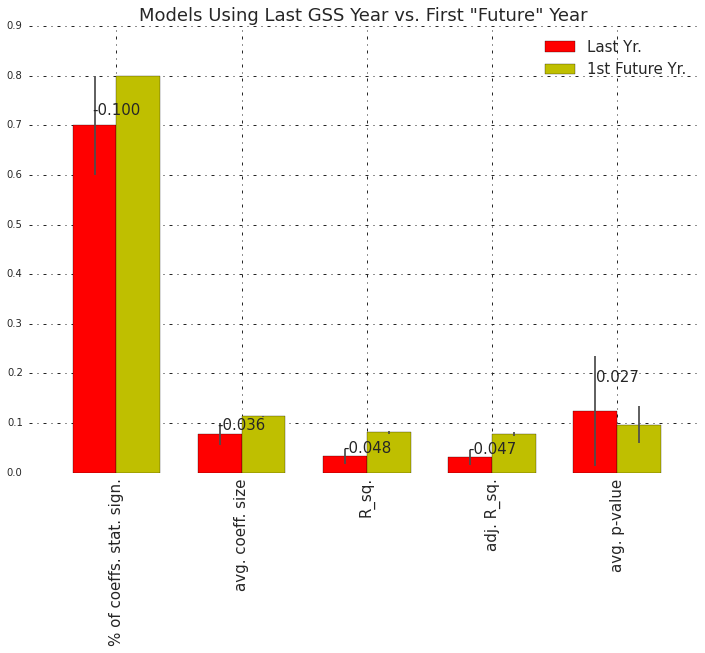

In [89]:
%matplotlib inline

outcomesToUse = df_output[group1].columns
indices = np.arange(len(outcomesToUse))
width = 0.35
axes = plt.figure(figsize=(12,8)).add_subplot(111)
error_config = {'ecolor': '0.3'}
rects1 = plt.bar(left=indices, width=width, height=df_output[group1].mean(), color='r', 
                 yerr=df_output[group1].std()/np.sqrt(len(df_output[group1])), error_kw=error_config) 
rects2 = plt.bar(left=indices+width, width=width, height=df_output[group2].mean(), color='y', 
                 yerr=df_output[group2].std()/np.sqrt(len(df_output[group2])), error_kw=error_config)

# title, legend, etc
plt.title('Models Using Last GSS Year vs. First "Future" Year', fontsize=18)
plt.legend((rects1[0], rects2[0]), ('Last Yr.', '1st Future Yr.'), fontsize=15)
plt.xlim((-1*width, len(outcomesToUse)))

# tick labels
# a = outcomesToUse
a = ['% of coeffs. stat. sign.', 'avg. coeff. size', 'R_sq.', 'adj. R_sq.', 'avg. p-value', \
     '"central" vars: % of coeffs. stat. sign.', '"central" vars: avg. coeff. size', '"central" vars: avg. p-value']
axes.set_xticks(indices+width)
axes.set_xticklabels(a, rotation=90, fontsize=15)

# label the bars with the difference between them
diffs = (df_output[group1] - df_output[group2]).mean().values
def autolabel(rects):
    # attach some text labels
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if i!=7 and i!=4:
            axes.text(rect.get_x()+width, 1.02*height, '%0.3f'%diffs[i],
                    ha='center', va='bottom', fontsize=15)
        else: # this is for the p-value label, which has gone up
            axes.text(rect.get_x()+width, 1.02*height+0.05, '%0.3f'%diffs[i],
                    ha='center', va='bottom', fontsize=15)
autolabel(rects1)

# savefig('../../Images/ASA2015/models_using_last_gss_year_vs_first_future_year.png', bbox_inches='tight')

In [3]:
# print outcomesToUse
# print 
# print diffs
# print
# print diffs_strings

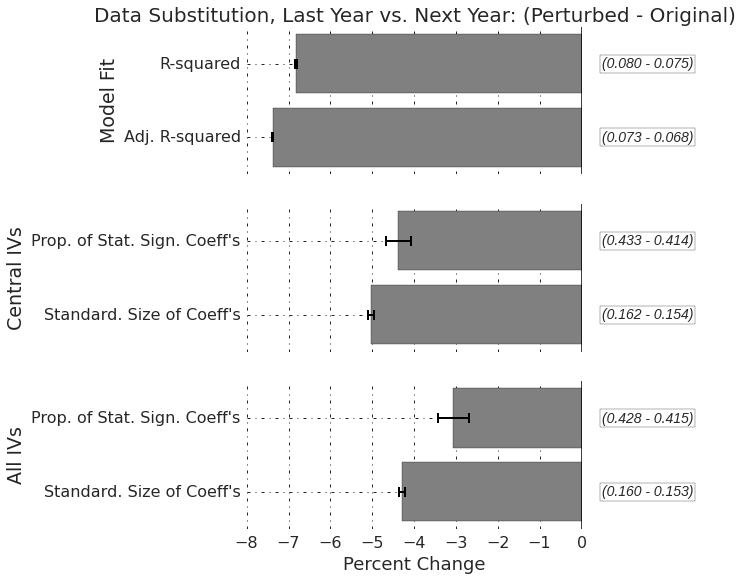

In [74]:
%matplotlib inline

# fig = plt.figure(figsize=(6,9))
outcomesToUse = [u'adjRs',
                 u'Rs',
                 u'paramSizesNormed_CentralVars',                
                 u'propSig_CentralVars', 
                 u'paramSizesNormed',
                 u'propSig']

outcomeMap = {'propSig':"Prop. of Stat. Sign. Coeff's", 
              'paramSizesNormed':"Standard. Size of Coeff's",
              'Rs':'R-squared', 
              'adjRs':'Adj. R-squared',
#               'pvalues':"Avg. P-Value of Coeff's",
              'propSig_CentralVars':"Prop. of Stat. Sign. Coeff's",
              'paramSizesNormed_CentralVars':"Standard. Size of Coeff's", 
              'pvalues_CentralVars':"Avg. P-Value of Coeff's"}

# indices = [1,2,4,5,7,8]
width = 0.5
error_config = dict(ecolor='0', lw=2, capsize=5, capthick=2)

diffs = [100*(df_output[group2, outcome] - df_output[group1, outcome]).mean()/df_output[group1, outcome].mean() for outcome in outcomesToUse]
diffs_strings = ['(%0.3f - %0.3f)' % (df_output[group1, outcome].mean(), df_output[group2, outcome].mean()) 
                 for outcome in outcomesToUse]
diffs = np.array(diffs)

# naive SES
# ses = [(df_output[group1, outcome] - df_output[group2, outcome]).std()/np.sqrt(len(df_output)) for outcome in outcomesToUse]

# clustered SES
clusteredSES = []
article_ids = np.array(list(df_output.index)) 
for outcome in outcomesToUse:
    diff = 100*(df_output[group2, outcome] - df_output[group1, outcome])
    mask = ~np.isnan(np.array(diff))
    result_clustered = smf.ols(formula='y~x-1', \
                     data=pd.DataFrame({'y':diff[mask], 'x':[1]*len(diff[mask])})).fit(missing='drop', \
                                                                             cov_type='cluster', \
                                                                    cov_kwds=dict(groups=article_ids[mask]))
    clusteredSES.append(result_clustered.HC0_se[0])
clusteredSES = np.array(clusteredSES)

colors = ['0.5' if el < 0 else '0.85' for el in diffs]

# plt.barh(indices, diffs, xerr=2*np.array(clusteredSES), align='center', color=colors, error_kw=error_config)
# axes.set_yticks(indices)
# axes.set_yticklabels([outcomeMap[o] for o in outcomesToUse], fontsize=17)

f, axarr = plt.subplots(3, sharex=True, figsize=(6,9))
                        
for i in range(3):
    # bars
    xerr = 2*clusteredSES[i*2:i*2+2] / diffs[i*2:i*2+2] # i am dividing here because we want the SEs to be on the percent-change scale, not raw scale
    boxes = axarr[i].barh([0,1], diffs[i*2:i*2+2], xerr=xerr, 
             align='center', color=colors[i*2:i*2+2], error_kw=error_config)

    # annotate boxes: raw means
    box0_xcoord = boxes[0].get_bbox().get_points()[1,0] + .5 # the indices here mean get the x-coord of 2nd box corner
    box1_xcoord = boxes[1].get_bbox().get_points()[1,0] + .5

    axarr[i].text(box0_xcoord, 0, diffs_strings[i*2], fontsize=14,
                 verticalalignment='center',
                 bbox=dict(facecolor='white', alpha=1), style='italic')
    axarr[i].text(box1_xcoord, 1, diffs_strings[i*2+1], fontsize=14,
                 verticalalignment='center',
                 bbox=dict(facecolor='white', alpha=1), style='italic')

    #labels for y-axis
    axarr[i].set_yticks([0,1])
    axarr[i].set_yticklabels([outcomeMap[o] for o in outcomesToUse[i*2:i*2+2]], fontsize=16)
    axarr[i].plot([0,0], [-0.5,1.5], linewidth=2, c='black', alpha=.75)        
    
axarr[0].set_title('Data Substitution, Last Year vs. Next Year: (Perturbed - Original)', fontsize=20)
axarr[0].set_ylabel('Model Fit', fontsize=19)
axarr[1].set_ylabel('Central IVs', fontsize=19)
axarr[2].set_ylabel('All IVs', fontsize=19)
axarr[2].set_xlabel('Percent Change', fontsize=18)
plt.xticks(fontsize=16)
# plt.xlim(-10, 50)

# plt.title('Original vs. Cognate Models', fontsize=20)
# plt.xlabel('% change from original to cognate', fontsize=17)
# plt.xticks(fontsize=15)

# plt.plot([0,0], [-0.5,7.5], linewidth=2, c='black', alpha=.75)

plt.savefig('images/last-vs-next--original-minus-perturbed.svg', bbox_inches='tight', dpi=150)

Perform t-tests
--

In [ ]:
# import rpy2.robjects as robjects
# import pandas.rpy.common as com
# from rpy2.robjects import pandas2ri
# pandas2ri.activate()
# r = robjects.r

# article = articlesToUse[10]
# mydf = dataCont.df.loc[1974, article.DVs+article.IVs]
# mydf.head()

In [16]:
# # (df_output['adjRs','orig. models'] - df_output['adjRs','cognate models']).plot(kind='kde')

# from scipy.stats import ttest_1samp
# for outcome in outcomes:
#     print outcome
#     print 'mean group 1', df_output[group1, outcome].mean()
#     print 'mean group 2', df_output[group2, outcome].mean()
#     print ttest_rel(df_output[group1, outcome], df_output[group2, outcome])[1]
#     print

Perform t-tests and Tests using *clustered errors*
--

1. Perform related-sample t-test (samples must be of equal lengths)

2. Perform independent samples t-test (just for kicks, to see how big our effects are)

3. Perform clustered error tests. To do this I will do a hack by running a regression with clustered errors and using that as the t-test. Source/inspiration is: http://www.stata.com/statalist/archive/2010-05/msg00663.html

Note: I am not using the 'df_correction' flag in get_robustcov_results() because that's apparently something HLM does, not canonical clustered errors:
"This method of correcting the standard errors to account for the intraclass correlation is a "weaker" form of correction than using a multilevel model, which not only accounts for the intraclass correlation, but also corrects the denominator degrees of freedom for the number of clusters."
source: http://www.ats.ucla.edu/stat/stata/library/cpsu.htm

Note
--
For some reason, I'm getting different clustered-errors-p-values when I use the 'cluster' flag in the 
fit() function vs. when I calculate the result normally and then use get_robustcov_results function on that result. The former method yields slightly smaller p-values.

Outcome
--
The p-values are larger (for some outcomes, they are now > 0.05) but are still sufficiently small?


In [17]:
# (df_output['adjRs','orig. models'] - df_output['adjRs','cognate models']).plot(kind='kde')

from scipy.stats import ttest_rel
import statsmodels.formula.api as smf

for outcome in outcomes:
    print outcome
    print 'Mean before substitution:', np.around(df_output[group1, outcome].mean(), 3)
    print 'Mean after substitution:', np.around(df_output[group2, outcome].mean(), 3)
    print 'Related samples t-test p-value:', np.around(ttest_rel(df_output[group1, outcome], df_output[group2, outcome])[1], 6)
 
    # GET CLUSTERED ERRORS
    # to do this run a regression Y ~ X where Y = outcomes, X = dummy {0=group1, 1=group2}
    # 1. Define variables
    outcomes_combined = list(df_output[group1, outcome]) + list(df_output[group2, outcome])
    diffs = df_output[group1, outcome] - df_output[group2, outcome]
    dummy = [0]*len(df_output[group1, outcome]) + [1]*len(df_output[group2, outcome])
    
    # 2. Fit models
#     result = smf.ols(formula='y~x', data=pd.DataFrame({'y':outcomes_combined, 'x':dummy})).fit() # do I need a constant???
#     result = smf.ols(formula='y~x-1', data=pd.DataFrame({'y':diffs, 'x':[1]*len(diffs)})).fit()
    result_clustered = smf.ols(formula='y~x-1', \
                     data=pd.DataFrame({'y':diffs, 'x':[1]*len(diffs)})).fit(missing='drop', \
                                                                             cov_type='cluster', \
                                                            cov_kwds=dict(groups=df_output.article_id))
                                                                                               
# these two methods produce slightly different results. neither is necessary because i'm using parameters
# of the model.fit() method above instead to use clustered standard errors.
#     # 3. Get clustered standard errors
#     robust_results = result.get_robustcov_results(cov_type='cluster', 
#                                                   use_correction=True,
#                                                   groups=article_ids, # this is article_id doubled
#                                                   df_correction=True) 
    
#     # 3.1 Get clustered standard errors another way, by regression diffs ~ const and seeing if const!=0
#     result_rob = result.get_robustcov_results(cov_type='cluster', \
#                                            groups=article_ids) # this is article_id singled
    
    print 'Clustered errors p-value:', np.around(result_clustered.pvalues[0], 3)    
#     print 'clustered errors p-value:', np.around(result_rob.pvalues[0], 3)
    print

propSig
Mean before substitution: 0.475
Mean after substitution: 0.477
Related samples t-test p-value: 0.731899
Clustered errors p-value: 0.803

paramSizesNormed
Mean before substitution: 0.167
Mean after substitution: 0.162
Related samples t-test p-value: 0.001963
Clustered errors p-value: 0.058

Rs
Mean before substitution: 0.094
Mean after substitution: 0.091
Related samples t-test p-value: 9.6e-05
Clustered errors p-value: 0.003

adjRs
Mean before substitution: 0.088
Mean after substitution: 0.085
Related samples t-test p-value: 0.000476
Clustered errors p-value: 0.007

pvalues
Mean before substitution: 0.23
Mean after substitution: 0.232
Related samples t-test p-value: 0.69056
Clustered errors p-value: 0.768

propSig_CentralVars
Mean before substitution: 0.479
Mean after substitution: 0.483
Related samples t-test p-value: nan


ValueError: The weights and list don't have the same length.

How many models' avg p-value is above 0.05?
--

In [ ]:
# # need to see tally up how switched from being below to being above
# # i.e. need to condition on being below beforehand, and how many of those are above now

# print 'count:', df_output[group2]['pvalues'][df_output[group2]['pvalues'] > 0.05].shape[0]
# print 'total:', df_output.shape[0]
# print 'percent:', df_output[]['pvalues'][df_output['cognate models']['pvalues'] > 0.05].shape[0]/ df_output.shape[0]